In [64]:
import numpy as np
import pandas as pd
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

- https://github.com/akshaykanehitlu/Credit-Card-Fraud-Detection-ML/blob/main/creditcard.csv

In [107]:
data = pd.read_csv("creditcard.csv.gz")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.loc[:, "V1":"V28"].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


In [123]:
sequence_length = 20
n_features = 28

In [124]:
def generate_data(X, y, sequence_length = sequence_length, step = 1):
    X_local = []
    y_local = []
    for start in range(0, len(data) - sequence_length, step):
        end = start + sequence_length
        X_local.append(X[start:end])
        y_local.append(y[end-1])
    return np.array(X_local), np.array(y_local)

X_sequence, y = generate_data(data.loc[:, "V1":"V28"].values, data.Class)

In [125]:
X_sequence.shape, y.shape

((284787, 20, 28), (284787,))

In [126]:
keep_pct = 0.2
idx_majority = np.where(y == 0)[0]
idx_to_del = np.random.choice(idx_majority,int((1-keep_pct)*X_sequence.shape[0]))

In [127]:
X_sequence_red = np.delete(X_sequence,idx_to_del,axis=0)
y_red = np.delete(y,idx_to_del,axis=0)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_sequence_red, y_red, test_size=0.3, random_state=42,stratify=y_red)
X_train.shape, X_test.shape, Counter(y_train),Counter(y_test)

((89655, 20, 28),
 (38424, 20, 28),
 Counter({0: 89311, 1: 344}),
 Counter({0: 38276, 1: 148}))

In [129]:
dim_hidden1 = 20
dim_hidden2 = 10

model = Sequential()
model.add(LSTM(dim_hidden1, input_shape = (sequence_length, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(dim_hidden2, input_shape = (sequence_length, n_features), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", metrics=[binary_accuracy], optimizer="adam")
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 20, 20)            3920      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 5,171
Trainable params: 5,171
Non-trainable params: 0
_________________________________________________________________


In [130]:
batch_size = 64
epochs = 50
validation_split = 0.1

history = model.fit(
    X_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=validation_split,
    callbacks = [EarlyStopping(monitor='val_loss', patience=8)]
) 

Epoch 1/50
1261/1261 [==============================] - 46s 29ms/step - loss: 0.0459 - binary_accuracy: 0.9927 - val_loss: 0.0130 - val_binary_accuracy: 0.9957
Epoch 2/50
1261/1261 [==============================] - 40s 32ms/step - loss: 0.0099 - binary_accuracy: 0.9962 - val_loss: 0.0103 - val_binary_accuracy: 0.9957
Epoch 3/50
1261/1261 [==============================] - 40s 32ms/step - loss: 0.0081 - binary_accuracy: 0.9962 - val_loss: 0.0093 - val_binary_accuracy: 0.9957
Epoch 4/50
1261/1261 [==============================] - 38s 31ms/step - loss: 0.0077 - binary_accuracy: 0.9964 - val_loss: 0.0096 - val_binary_accuracy: 0.9957
Epoch 5/50
1261/1261 [==============================] - 38s 30ms/step - loss: 0.0071 - binary_accuracy: 0.9983 - val_loss: 0.0095 - val_binary_accuracy: 0.9988
Epoch 6/50
1261/1261 [==============================] - 39s 31ms/step - loss: 0.0069 - binary_accuracy: 0.9989 - val_loss: 0.0095 - val_binary_accuracy: 0.9988
Epoch 7/50
1261/1261 [==================

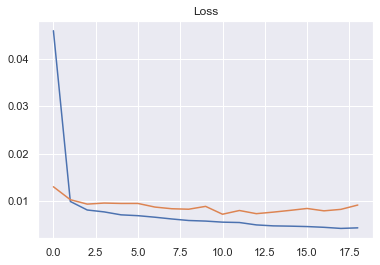

In [131]:
plt.title('Loss')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

In [132]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

1201/1201 [==============================] - 16s 14ms/step - loss: 0.0070 - binary_accuracy: 0.9990 1 - ETA: 9s - loss - ETA: 7s - loss: 0.0061 - bin
test loss, test acc: [0.007008067332208157, 0.9989590048789978]


In [133]:
y_test_prob = model.predict(X_test, verbose=1)

1201/1201 [==============================] - 19s 13ms/step


In [134]:
y_test_pred = np.where(y_test_prob > 0.8, 1, 0)

In [135]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38276
           1       0.93      0.78      0.85       148

    accuracy                           1.00     38424
   macro avg       0.97      0.89      0.92     38424
weighted avg       1.00      1.00      1.00     38424



In [136]:
print(confusion_matrix(y_test, y_test_pred))

[[38268     8]
 [   33   115]]
